# Learning to Sample Ray Paths for Faster Ray Tracing

In this notebook, we present a Machine Learning model,
based on the GFlowNet architecture {cite}`gflownet`,
that tries to learn how to sample valid ray paths
to reduce the overall computational complexity of Ray Tracing (RT).

Our model also takes inspiration from the Deep Sets
{cite}`deepsets` to provide invariance with permutations in the input,
as well as allowing to scene to be arbitrary large.

:::{note}
When writing this notebook and the Machine Learning Model,
we took a great inspiration from the [GFlowNet tutorial from Emmanuel Bengio](https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR).
:::

## Introduction

When modeling radio propagations, RT is often used as a mean to evaluate of the trajectories
that some radio waves can take to reach a given receiving antenna (RX), as emitted from a
transmitting antenna (TX).

For this RT variant, also known as Point-to-Point (P2P) RT, we are interested
in listing all the possible physical paths from TX to RX, that undergo up-to a fixed number
of interaction, referred to as `order` in the code.

After pre-processing the input scene, tracing those paths is usually a two-steps process:

1. listing all possible path candidates between TX and RX;
2. and for each path candidate, (a) tracing the physical path, and (b) removing paths that
   are physically invalid (e.g., intersecting with any other object in the scene).

In many applications, we can represent each path candidate as a list of object indices,
where each index indicates on which object the path should *interact* with.

E.g., in the restricted context of specular reflections on flat walls, `walls`,
`path_candidate = [5, 3, 6]` indicates a path that undergoes 3 *reflections* between
TX anx RX. The first one is on `walls[5]`, then the second is on `walls[3]`, and the
third on `walls[6]`. Using this order sequence of wall indices, we can then easily
construct the geometrical path of the ray, using, e.g., the image method.

In [1]:
# A few importants imports to be able to run our code
# 'type hint' related imports are only here for help documenting the code!

from collections.abc import Iterator
from typing import Any

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, Int, PRNGKeyArray, Shaped, jaxtyped
from tqdm.notebook import trange

from differt2d.geometry import ImagePath, Point, Wall
from differt2d.logic import is_true
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Motivation

When performing P2P RT, enumerating all possible path candidates is usually the
step that takes the most time, as the number of possible path candidates is in
the order of $\mathcal{O}(\texttt{num_walls}^\texttt{order})$. In large scenes,
this number can become dramatically large. This number can be largely decreased
if one knows the visibility matrix (or visibility tree, TODO CITE) of the scene,
but such a matrix is not really easy too obtain (and can be also very costly
to generate).

However, not all path candidates will lead a valid geometrical ray paths.
As such, **our model aims at directly sampling the path candidates that are
very likely to produce a valid ray path**, in order to reduce the overall complexity.

### A basic scene with all valid ray paths

To illustrate our challenge, we will first plot all the
valid second-order (`order=2`) ray paths in a basic scene
with one square obstacle.

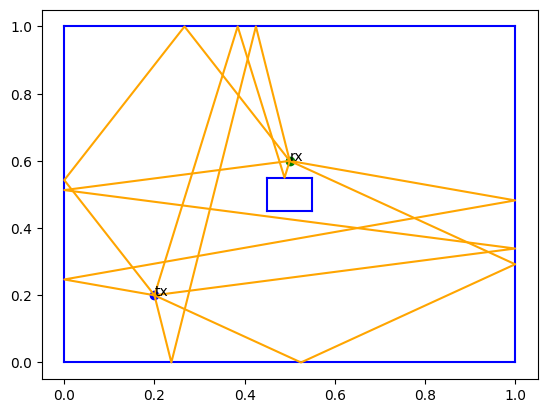

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

xlim = plt.xlim()
ylim = plt.ylim()

plt.show()

### A basic scene with all valid and invalid ray paths

In the above figure, we only showed *valid* ray paths.
But what would happen if we also showed the *invalid* ones,
i.e., the geometrical paths as generated by path candidates
that **did not lead** to a valid path?

This is what we show in the next cell.

Found 6 valid path candidates, and 50 invalid path candidates,
which translates to 10.71% of path candidates being valid.


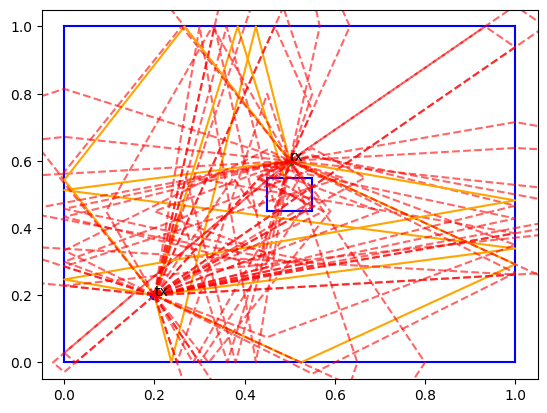

In [3]:
ax = plt.gca()
scene.plot(ax)

num_valid_path_candidates = 0
num_invalid_path_candidates = 0

for _, _, valid, path, _ in scene.all_paths(min_order=order, max_order=order):
    if is_true(valid):
        num_valid_path_candidates += 1
        path.plot(ax)
    else:
        num_invalid_path_candidates += 1
        path.plot(ax, linestyle="--", color="red", alpha=0.6)

print(
    f"Found {num_valid_path_candidates} valid path candidates, "
    f"and {num_invalid_path_candidates} invalid path candidates,\n"
    "which translates to "
    f"{100 * num_valid_path_candidates / (num_valid_path_candidates + num_invalid_path_candidates):.2f}% "
    "of path candidates being valid."
)

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.show()

As you can see, only a small fraction of the path candidates result
in valid ray paths (orange solide lines).

For sure, this fraction can change with respect with the input scenem
but our model's hypothesis is that the number valid paths is usually
much smaller than the total number of path candidates.

## Model's goals

As described above, our model should take as input (1) the input geometry (TX, RX, and objects' coordinates),
and (2) the order of the path. Its output should be a high-reward[^1] path candidate that undergoes
`order` interaction with the scene's objects. To obtain more path candidates, we should simply query the
model multiple times.

Moreover, we want our model to be **invariant** with respect to the ordering of the objects,
and accept **arbitrary many** objects. Those properties are achieved using a Deep Sets-like
architecture when transforming the input scene.

[^1]: Here, the reward is high if the path candidate leads to a physically valid ray path.

### Note about reproducibility

As we need randomness at various stages of this notebook,
to generate the training data,
to initialize the model's weights,
and to sample path candidates with our model,
we will first fix the random seed, the all the results below just
be reproducible locally, on any computer.

JAX is very different to NumPy, TensorFlow, and other array libraries, as it needs an explicit
*Pseudo Random Generator Key* for each random data generation. Other libraries usually have it
optional, and will work just fine by setting a `random.seed` at the very top of the project.

Because JAX aims to produce reproducible, parallelizable, and vectorisable results, you
**must** explicitly pass a PRNG key for each random numbers generation.

The best practice is then to start from one unique *seed* key, and split it
as many times as we need to generate random numbers. It is also best practice not
to reuse a PRNG key for two different random numbers generations.

For more details, read
[JAX's tutorial on pseudorandom numbers](https://jax.readthedocs.io/en/latest/random-numbers.html).

In [4]:
key = jax.random.PRNGKey(12345)  # 12345 is the 'random seed'
key, key_example_scene = jax.random.split(key, 2)

## Training data generation

For this example, we limit ourselves to the study of specular reflection paths
on straight walls. This is, of course, not a limitation of our model.

We generate data by applying random modifications on the very basic
*square scene with obstacle*. The training data is simply a never ending
iterator, which makes it very convenient of we want to increase the number
of training steps.

As every training sample is different, there is not realy need to have both
a training set and a test set.

Also, the GFlowNet architecture has the advantage that we **do not** actually need
the have a ground truth. Indeed, we generate here the set of all valid path candidates
to make the reward function simpler, but we could very well compute the validity of
some path candidate **within** the reward function (instead of using the ground truth
as a *look-up table*) to avoid enumerating all possible paths during training.

In [5]:
def random_scenes(
    min_ratio: float = 0.20,
    max_ratio: float = 0.40,
    min_num_walls: int = 4,
    min_angle: float = -0.1 * jnp.pi,
    max_angle: float = +0.1 * jnp.pi,
    *,
    key: PRNGKeyArray,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    """
    Returns a generator of random variants of :func:`Scene.square_scene_with_obstacle`.

    The generation follows a three-steps process:

    1. generate a ``square_scene_with_obstacle`` with a random scaling ratio;
    2. sample a random number of walls from this scene;
    3. and apply a random rotation around the scene's center for each wall.

    :param min_ratio: The minimum scaling ratio of the inner square obstacle.
    :param min_ratio: The maximum scaling ratio of the inner square obstacle.
    :param min_num_walls: The minimum number of walls to sample (maximum is 8).
    :param min_angle: The minimum rotation angle (random for each wall).
    :param max_angle: The maximum rotation angle (random for each wall).
    :param key: The random key to be used.
    """
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def random_samples(
    order: int, **kwargs: Any
) -> Iterator[tuple[Float[Array, "2+num_walls*2 2"], Int[Array, "num_paths {order}"]]]:
    """
    Returns a generator of random (train or test) samples for the model.

    :param order: The order of the paths to generate.
    :param kwargs: Keyword arguments passed to :func:`random_scenes`.
    :return: A generator of (scene coordinates, path_candidates).
    """
    for scene, points in random_scenes(**kwargs):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        # Handle edge case with no path
        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.int32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.int32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

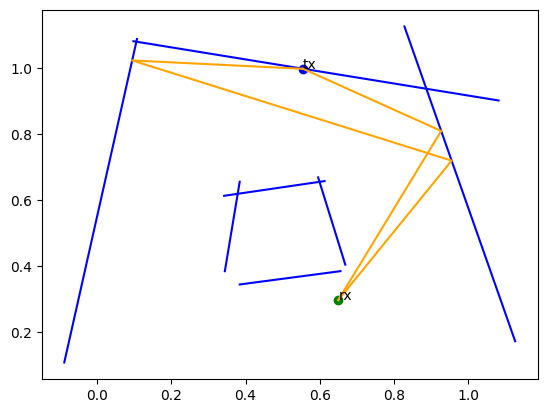

In [6]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(order=order):
    path.plot(ax)

plt.show()

In [7]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)

# Let's filter out the cases with not valid paths,
# because they are not interesting to learn from.

train_samples = filter(
    lambda args: args[1].shape[0] > 0, random_samples(order=order, key=key_samples)
)

In [8]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def row_in_matrix(
    row: Shaped[Array, " num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " "]:
    """
    Returns whether a row can be found in the rows of the given matrix.

    :param row: The row to look for.
    :param matrix: The matrix.
    :return: Whether the row is in the matrix.
    """
    bool_ = jax.vmap(jnp.equal, in_axes=(None, 0))(row, matrix)
    return jnp.any(jnp.all(bool_, axis=1), axis=0)


@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidate: Int[Array, "order"],
    true_path_candidates: Int[Array, "num_paths order"],
) -> Float[Array, " "]:   
    """
    Rewards a predicted path candidate depending on its presence in the set of valid path candidates.

    :param pred_path_candidate: The predicted path candidate.
    :param true_path_candidates: The set of valid path candidates.
    :return: The (positive) reward.
    """
    pred_in_true = row_in_matrix(pred_path_candidate, true_path_candidates)

    return jnp.sum(pred_in_true.astype(float))

In [9]:
true_path_candidates = jnp.array([[0, 1], [2, 4], [3, 1]])

# 1 - Valid path
pred_path_candidate = jnp.array([2, 4])

print(f"1 Valid   - {reward(pred_path_candidate, true_path_candidates) = }")

# 2 - Invalid path
pred_path_candidate = jnp.array([2, 5])

print(f"2 Invalid - {reward(pred_path_candidate, true_path_candidates) = }")

1 Valid   - reward(pred_path_candidate, true_path_candidates) = Array(1., dtype=float32)
2 Invalid - reward(pred_path_candidate, true_path_candidates) = Array(0., dtype=float32)


## Model definition

Our model follows the architecture of GFlowNet models: the goal is to learn how sample path candidates
(here, the last state of the diagram) such that their samplin rate is proportional to their corrsponding
reward.

A path candidate is simply a list of wall indices, e.g., `[2, 0, 1]`. A path candidate under
construction (i.e., not yet completed), is represented with `X` for undecided states.

E.g., `path_candidate = [2, 0, X]` indicates a path with 3 interactions, where the two first
are already defined (i.e., object `2` then object `0`).

For each path, there is a unique state $S$ representing it. For convenience, states
are obtained by encoding the corresponding path candidate using one-hot encoding.

E.g., `path_candidate = [2, 0, X]` is represented by the following state
(assuming 3 objects in the scene):

```python
state = [
  [0, 1, 0],
  [0, 0, 0],
  [1, 0, 0],
]
```

The last column being all zeros refers to the `X`.

Below, the diagram of all possible states is shown. As interacting with the same
object twice in a row is **physically unsound**, this state is **unreachable** (dotted lines).
To account for that in the model, the flow is stopped to prevent reaching those states.

```{mermaid}
:align: center
:caption: Diagram of all possible states for a 3-order path candidates in a scene with 3 walls.

flowchart TD
    X(XXX) -->|0| A(0XX)
    X -->|1| B(1XX)
    X -->|2| C(2XX)

    A -.-x|0| AA(00X)
    A -->|1| AB(01X)
    A -->|2| AC(02X)

    B -->|0| BA(10X)
    B -.-x|1| BB(11X)
    B -->|2| BC(12X)

    C -->|0| CA(20X)
    C -->|1| CB(21X)
    C -.-x|2| CC(22X)

    AB -->|0| ABA(010)
    AB -.-x|1| ABB(011)
    AB -->|2| ABC(012)

    AC -->|0| ACA(020)
    AC -->|1| ACB(021)
    AC -.-x|2| ACC(022)

    BA -.-x|0| BAA(100)
    BA -.-x|1| BAB(101)
    BA -->|2| BAC(102)

    BC -->|0| BCA(120)
    BC -->|1| BCB(121)
    BC -.-x|2| BCC(122)

    CA -.-x|0| CAA(200)
    CA -->|1| CAB(201)
    CA -->|2| CAC(202)

    CB -->|0| CBA(210)
    CB -.-x|1| CBB(211)
    CB -->|2| CBC(212)
```

In [10]:
class FlowModel(eqx.Module):
    # Layers
    wall_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each wall in parallel and returns the corresponding embeddings."""
    embeddings_2_flow: eqx.nn.MLP
    """MLP that maps each possible choice to some positive flow."""

    def __init__(
        self,
        # Hyperparameters
        num_embeddings: int = 100,
        *,
        key: PRNGKeyArray,
    ):
        """
        Constructs a GFlowNet model.
        
        :param num_embeddings: The size of the vector that will represent each wall.
        :param key: The random key to be used.
        """
        key1, key2 = jax.random.split(key, 2)
        
        # Layers
        self.wall_2_embeddings = eqx.nn.MLP(
            in_size=4,
            out_size=num_embeddings,
            width_size=500,
            depth=3,
            key=key1,
        )
        self.embeddings_2_flow = eqx.nn.MLP(
            in_size=4 + 2 * num_embeddings + 4,  # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,  # Positive flow only
            key=key2,
        )

    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        state: Float[Array, "num_walls order"],
        wall_index: Int[Array, " "],
        xys: Float[Array, "2+num_walls*2 2"],
    ) -> Float[Array, "num_walls"]:
        """
        Calls this model in order to generate a new flow from a given state,
        the last selected wall index, and some input scene.

        :param state: The current state, a one-hot encoding of the path candidate
            in construction. Only one element per column can be non-zero.
        :param wall_index: The index of the last wall that was selected. A negative index
            indicates that no wall was previously selected.
        :param xys: The array of xy-coordinates, as returned by
            :func:`random_samples`.
        :return: The array of flows, one per wall in the scene.
        """
        assert (
            xys.shape[0] >= 4
        ), "Scene must at least have two points, tx and rx, and one wall!"

        num_walls, order = state.shape

        # Data normalization
        eps = 1e-5
        mean = jnp.mean(xys, axis=0, keepdims=True)
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - mean) / (std + eps)

        tx_rx = xys[:2, :].reshape(4)
        walls = xys[2:, :].reshape(num_walls, 4)

        # [num_walls 4]
        # note: this input we be the same for every wall
        tx_rx = jnp.tile(tx_rx, (num_walls, 1))

        # [num_walls num_embeddings]
        # note: each wall is mapped to a vector of embeddings
        walls_embeddings = jax.vmap(self.wall_2_embeddings)(walls)

        # [num_embeddings]
        # note: the scene is the sum of all embeddings
        scene_embeddings = jnp.sum(walls_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        scene_embeddings = jnp.tile(scene_embeddings, (num_walls, 1))

        # [order]
        # note: fill_value=num_walls is important as we need to generate 'out of bounds'
        #       indices for missing values (only current_order <= order are non zero)
        wall_indices, _ = jnp.nonzero(state, size=order, fill_value=num_walls)

        # [order num_embeddings]
        # note: we tell JAX to replace 'out of bounds' indices with zeros,
        #       as this will have no impact on the sum (see next step)
        state_embeddings = jnp.take(
            walls_embeddings, wall_indices, axis=0, fill_value=0
        )

        #jax.debug.print("state_embeddings {s}", s=state_embeddings)

        # [num_embeddings]
        # note: this contains information about the walls we already visited,
        #       as a sum of corresponding embeddings (one wall can appear multiple times)
        state_embeddings = jnp.sum(state_embeddings, axis=0)

        # [num_walls num_embeddings]
        # note: this input we be the same for every wall
        state_embeddings = jnp.tile(state_embeddings, (num_walls, 1))

        # [num_walls]
        # note: the input (per wall) looks as follows
        #       # [tx_rx, state_embeddings, scene_embeddings, wall[i]]
        flow = jax.vmap(self.embeddings_2_flow)(
            jnp.hstack((tx_rx, state_embeddings, scene_embeddings, walls))
        )

        # Set flow[wall_index] to zero to prevent consecutive duplicate indices
        # A flow of zero means that there is a zero probability to pick
        # walls[wall_index] for the next state.
        flow = flow.at[wall_index].set(0.0)  # out of bounds indices are ignored

        return flow

## Loss function definition

<TODO: rewrite this>

A central finding of the first GFlowNet paper is that if we match to each edge a _flow_, $F(s,s')>0$, and that this flow respects the following property:
$$\forall s', \sum_{s: (s,s')\in\mathcal{E}} F(s,s') = R(s') + \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')$$
which ensures _flow consistency_, then if we define the following policy:
$$P_F(s'|s) = \frac{F(s, s')}{\sum_{s''}F(s, s'')}$$
and sample trajectories (paths through the network) using this policy, we will sample terminal states (finished path candidates $x$) with probability:
$$p(x) \propto R(x)$$

We main difference our probability $p$ is **conditioned by the scene**:
$$p(x|G) \propto R(x, G),$$

where $G$ is an permutation-invariant commutative transformation of the input geometry.

In practice, the flow is computed at follows:

$$F(s,s') = f(\text{TX}, \text{RX}, G, s),$$

where $f$ is a combination of linear layers and non-linear activation functions.

In [11]:
@jaxtyped(typechecker=None)
def loss(
    model: FlowModel,
    xys: Float[Array, "2+num_walls*2 2"],
    true_path_candidates: Int[Array, "num_paths order"],
    batch_size: int = 10,
    plot: bool = False,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of 'batch_size' path candidates.
    """
    num_walls = (xys.shape[0] - 2) // 2
    order = true_path_candidates.shape[1]

    ScanR = Int[Array, " "]
    ScanC = tuple[
        Float[Array, " "],
        Float[Array, " num_walls"],
        ScanR,
        Float[Array, "num_walls order"],
    ]

    @jaxtyped(typechecker=typechecker)
    def scan_fn(
        carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]
    ) -> tuple[ScanC, ScanR]:
        # We carry, for the currently generated path candidates:
        # - the flow mismatch (parent edges flow - current flow)
        # - the parent edge flow (only one parent leads to the current choice)
        # - the parent wall index
        # - the state (path candidate using one-hot encoding)
        flow_mismatch, edge_flow_prediction, wall_index, state = carry
        key, current_order = key_and_current_order

        # Turn positive flow into normalized probability in [0, 1]
        p = edge_flow_prediction / jnp.sum(edge_flow_prediction)

        index = jax.random.categorical(key=key, logits=jnp.log(p))  # The wall to choose

        # Indicate we have chosen walls[wall_index] as a candidate at 'current_order'
        state = state.at[wall_index, current_order].set(1.0)

        parent_edge_flow_prediction = edge_flow_prediction  # The previous edge flow is the current flow's parent
        edge_flow_prediction = model(state, index, xys)

        pred_path_candidate = jnp.argmax(state, axis=0)

        flow_mismatch += jnp.where(
            current_order == order - 1,  # Check whether we reached final state
            (  # Reached last state so (next) edge_flow_prediction is ignored
                parent_edge_flow_prediction[
                    index
                ]  # Each state s' has only one possible parent state s
                - reward(pred_path_candidate, true_path_candidates)
            )
            ** 2,
            (  # Didn't reach last state so no reward
                parent_edge_flow_prediction[
                    index
                ]  # Each state s' has only one possible parent state s
                - jnp.sum(edge_flow_prediction)
            )
            ** 2,
        )

        return (flow_mismatch, edge_flow_prediction, wall_index, state), index

    BatchC = Float[Array, " "]
    BatchR = Int[Array, " order"]

    @jaxtyped(typechecker=typechecker)
    def batch_fn(batch_loss: BatchC, key: PRNGKeyArray) -> tuple[BatchC, BatchR]:
        flow_mismatch = jnp.array(0.0)  # We mismatch for the current path_candidate
        wall_index = jnp.array(num_walls)  # We didn't select any wall yet: out of bounds index
        state = jnp.zeros(
            (num_walls, order)
        )  # Same, but represented in one-hot encoding
        parent_edge_flow_prediction = model(state, wall_index, xys)  # Initial state's flow
        init = flow_mismatch, parent_edge_flow_prediction, wall_index, state
        (flow_mismatch, *_), pred_path_candidate = (
            jax.lax.scan(
                scan_fn,
                init,
                xs=(jax.random.split(key, order), jnp.arange(order)),
            )
        )

        # jax.debug.print("final = {pred_path_candidate}", pred_path_candidate=pred_path_candidate)

        return batch_loss + flow_mismatch, pred_path_candidate

    batch_loss = jnp.array(0.0)
    batch_loss, pred_path_candidates = jax.lax.scan(
        batch_fn, batch_loss, xs=jax.random.split(key, batch_size)
    )

    if plot:
        order = true_path_candidates.shape[1]
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        for _, _, path, _ in scene.all_valid_paths(order=order):
            gt, = path.plot(ax, color="orange")

        n_unique = 0
        for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
            n_unique += 1
            objects = [scene.objects[i] for i in pred_path_candidate]
            pr, = ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                ax, linestyle="--", alpha=0.5, color="red"
            )

        plt.title(f"Generated {batch_size} path cand. (of which {n_unique} are unique)")
        gt.set_label("Ground Truth")
        pr.set_label("Prediction")
        plt.legend()
        plt.show()

    return batch_loss

In [12]:
untrained_model = FlowModel(key=key_model)
optim = optax.adam(learning_rate=3e-4)

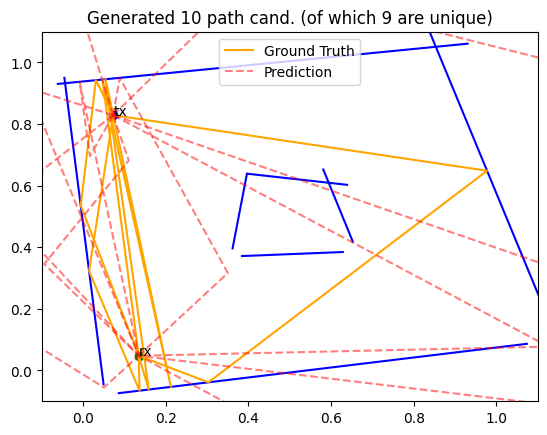

Array(397.2155, dtype=float32)

In [13]:
key, key_loss_untrained = jax.random.split(key, 2)
loss(
    untrained_model, *next(train_samples), plot=True, key=key_loss_untrained
)  # Untrained model

## Training phase

In [14]:
def train(
    model: FlowModel,
    train_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 10_000,
    print_every: int = 100,
    n: int = 100,
    *,
    key: PRNGKeyArray,
) -> tuple[FlowModel, Float[Array, "steps-n+1"]]:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: FlowModel,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    losses = []

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            losses.append(train_loss)
            if (step % print_every) == 0 or (step == steps - 1):
                bar.set_description(f"train_loss = {float(train_loss):.1f}")

    def moving_average(
        x: Shaped[Array, " steps"], n: int = 100
    ) -> Shaped[Array, "steps-n+1"]:
        r = jnp.cumsum(x)
        r = r.at[n:].add(-r[:-n])
        return r[n - 1 :] / n

    return model, moving_average(jnp.array(losses), n=n)

  0%|          | 0/10000 [00:00<?, ? steps/s]

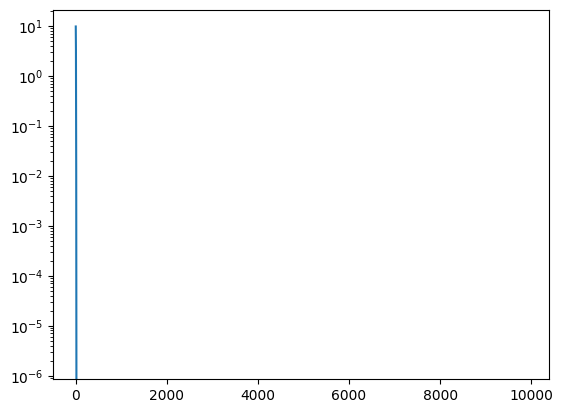

In [15]:
trained_model, losses = train(untrained_model, train_samples, optim, key=key_train)

plt.semilogy(losses)
plt.show()

## Inference phase

In [16]:
inference_model = eqx.nn.inference_mode(trained_model)  # This is a no-op (just copies the model)

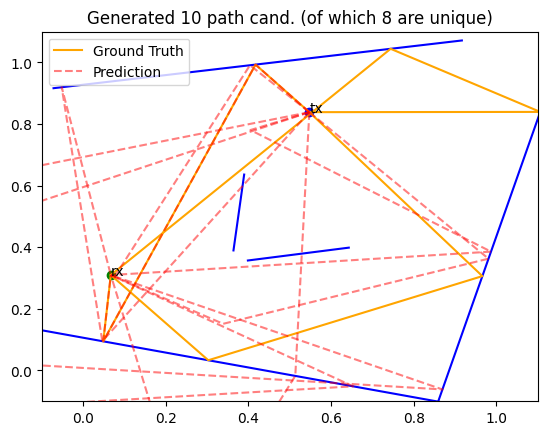

Array(1.6543554e-21, dtype=float32)

In [17]:
key, key_loss_trained = jax.random.split(key, 2)

loss(inference_model, *next(train_samples), plot=True, key=key_loss_trained)